# Part1

Importing needed libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.regularizers import l1,l2
import os
import imageio
import cv2
from keras.preprocessing.image import img_to_array
import re
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

**Data Preprocessing**

In [2]:
#extracting files from zipped folder 
!unzip "trainPart1.zip" -d "trainPart1"

Archive:  trainPart1.zip
   creating: trainPart1/train/
   creating: trainPart1/train/Sample002/
  inflating: trainPart1/train/Sample002/img002-048.png  
  inflating: trainPart1/train/Sample002/img002-050.png  
  inflating: trainPart1/train/Sample002/img002-006.png  
  inflating: trainPart1/train/Sample002/img002-004.png  
  inflating: trainPart1/train/Sample002/img002-053.png  
  inflating: trainPart1/train/Sample002/img002-045.png  
  inflating: trainPart1/train/Sample002/img002-052.png  
  inflating: trainPart1/train/Sample002/img002-047.png  
  inflating: trainPart1/train/Sample002/img002-020.png  
  inflating: trainPart1/train/Sample002/img002-009.png  
  inflating: trainPart1/train/Sample002/img002-011.png  
  inflating: trainPart1/train/Sample002/img002-013.png  
  inflating: trainPart1/train/Sample002/img002-034.png  
  inflating: trainPart1/train/Sample002/img002-038.png  
  inflating: trainPart1/train/Sample002/img002-024.png  
  inflating: trainPart1/train/Sample002/img002-0

Making image dataset from directory

I have used image_dataset_from_directory() fucntion from Keras Image data preprocessing utilities. This function takes data from a directory structure similar to given dataset and splits it into train and validation datasets. It returns a tf.data.Dataset object. 

I have imported images as "grayscale" because they are black and white so we don't need RGB channels. 
I have enabled "shuffle" while building dataset because the images are ordered according to classes and that ordering might cause a problem as training datsaet will be missing some classes and validation would have only few classes.

References - https://keras.io/api/preprocessing/
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory


In [3]:
image_size = (160,160)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/trainPart1/train",
    label_mode="categorical",
    color_mode = "grayscale",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=1337,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/trainPart1/train",
    label_mode="categorical",
    color_mode = "grayscale",
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    shuffle=True,
    subset="validation",
    seed=1337,
)

Found 2480 files belonging to 62 classes.
Using 1984 files for training.
Found 2480 files belonging to 62 classes.
Using 496 files for validation.


Visualising images from the dataset. One can see the shuffling here. 

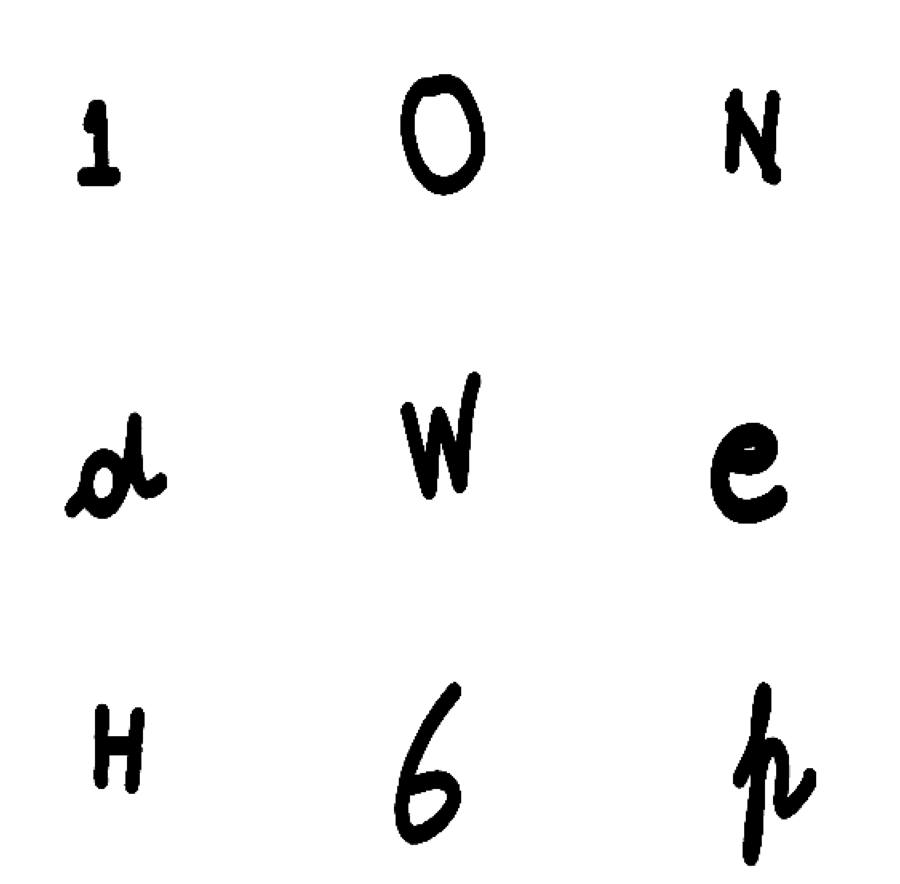

In [ ]:
plt.figure(figsize=(16,16))
for images, labels in train_ds.take(1):
    for i in range(0,9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().reshape(160,160), cmap="gray")
        plt.axis("off")

**Data Augmentation**

We have only 2480 images in total spanning 62 classes, which is just abou 54-55 images per class. This is very little data. 

Two major ways to deal with this are - 

1. Use pretrained model 
2. Use Data Augmentation to increase training data.

References -

Since the first option was forbidden, I have used Data Augmentation. This can be done in 2 ways - i) adding it in the model, ii) applying it to the dataset. I have added it in the model. 

References - https://www.tensorflow.org/tutorials/images/data_augmentation

https://keras.io/guides/preprocessing_layers/#keras-preprocessing-layers



In [4]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

Advantage of adding data augmentation in model - 

I have used only translation and rotation during data augmentation. I have disabled horizontal flip and vertical flip because those would cause misclassfication among (b,d) and and (6,9) respectively, and some more exapmles as well. 

Visualising Augmented data

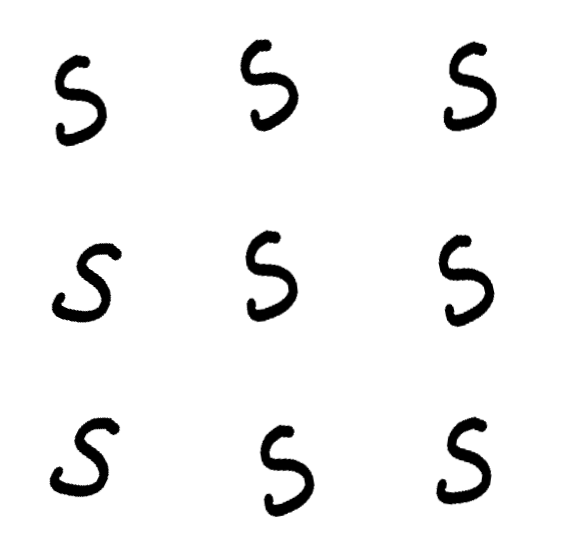

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().reshape(160,160), cmap="gray")
        plt.axis("off")

As one can see, the rotation and translation isn't too much. S still looks like S.

**Making a model**

**Model 1.1**

The idea of this model is pretty simple - there are a few convolution and maxpooling layers so that the patterns in images can be extracted. Then there is a flatten layer so as to generate input for dense layer. In the end, there are 2 dense layers. First one just takes information from the network and passes it forward to next dense layer, which classfies it into one of the 62 classes. This one has activation "softmax" because it is being used for multi class classification. 


In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)

    # 1st convolution layer
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # 2nd convolution layer
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # 2nd convolution layer
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # 3rd Convolution layer
    x = layers.Conv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = layers.Flatten()(x)
    # Dense layers
    #x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(units = num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


Building model and visualising it

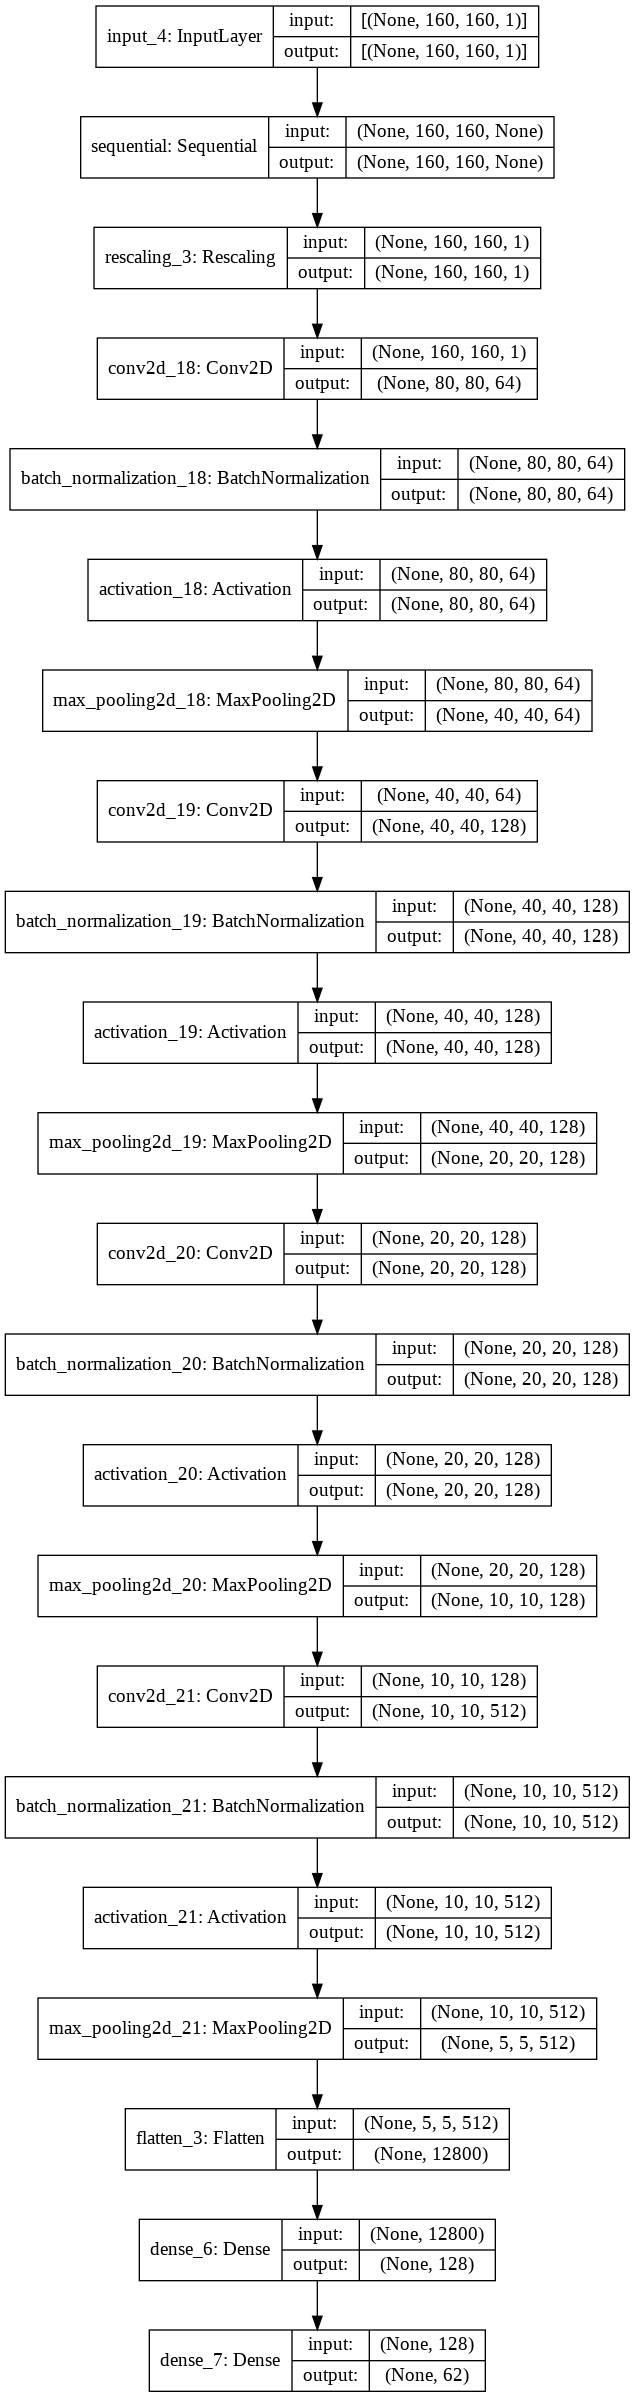

In [ ]:
model = make_model(input_shape=(160,160,1), num_classes=62)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 1)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, None)    0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 160, 160, 1)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 80, 80, 64)        640       
_________________________________________________________________
batch_normalization_18 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 80, 80, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 40, 40, 64)        0   

Checking size of train and validation datasets before fitting model

In [ ]:
print(train_ds)
print(val_ds)

<BatchDataset shapes: ((None, 160, 160, 1), (None, 62)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 160, 160, 1), (None, 62)), types: (tf.float32, tf.float32)>


Compiling the model with SGD(lr=0.1, momentum =0.9)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

Fitting the model

In [ ]:
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
62/62 [==============================] - 38s 542ms/step - loss: 4.3610 - accuracy: 0.0193 - val_loss: 4.1368 - val_accuracy: 0.0181
Epoch 2/50
62/62 [==============================] - 36s 527ms/step - loss: 4.1277 - accuracy: 0.0127 - val_loss: 4.1465 - val_accuracy: 0.0202
Epoch 3/50
62/62 [==============================] - 36s 537ms/step - loss: 4.1275 - accuracy: 0.0190 - val_loss: 4.1554 - val_accuracy: 0.0202
Epoch 4/50
62/62 [==============================] - 36s 534ms/step - loss: 4.1272 - accuracy: 0.0148 - val_loss: 4.1612 - val_accuracy: 0.0202
Epoch 5/50
62/62 [==============================] - 36s 526ms/step - loss: 4.1267 - accuracy: 0.0154 - val_loss: 4.1633 - val_accuracy: 0.0202
Epoch 6/50
62/62 [==============================] - 35s 522ms/step - loss: 4.1276 - accuracy: 0.0196 - val_loss: 4.1556 - val_accuracy: 0.0222
Epoch 7/50
62/62 [==============================] - 36s 534ms/step - loss: 4.1266 - accuracy: 0.0186 - val_loss: 4.1257 - val_accuracy: 0.0202

The training and validation accuracy remains low throughout indicating that the model isn't learning anything. Let's try changing the learning rate.

Building a new instance and compiling the model with SGD(LR=0.1)

In [ ]:
model = make_model(input_shape=(160,160,1), num_classes=62)
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate = 0.1),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
62/62 [==============================] - 36s 509ms/step - loss: 25.3240 - accuracy: 0.0108 - val_loss: 4.1288 - val_accuracy: 0.0060
Epoch 2/50
62/62 [==============================] - 34s 503ms/step - loss: 4.1279 - accuracy: 0.0207 - val_loss: 4.1309 - val_accuracy: 0.0060
Epoch 3/50
62/62 [==============================] - 34s 501ms/step - loss: 4.1279 - accuracy: 0.0179 - val_loss: 4.1328 - val_accuracy: 0.0060
Epoch 4/50
62/62 [==============================] - 34s 496ms/step - loss: 4.1277 - accuracy: 0.0208 - val_loss: 4.1345 - val_accuracy: 0.0060
Epoch 5/50
62/62 [==============================] - 34s 492ms/step - loss: 4.1277 - accuracy: 0.0198 - val_loss: 4.1361 - val_accuracy: 0.0060
Epoch 6/50
62/62 [==============================] - 34s 503ms/step - loss: 4.1277 - accuracy: 0.0170 - val_loss: 4.1376 - val_accuracy: 0.0060
Epoch 7/50
62/62 [==============================] - 34s 501ms/step - loss: 4.1275 - accuracy: 0.0126 - val_loss: 4.1389 - val_accuracy: 0.006

KeyboardInterrupt: ignored

It is pretty clear that the network isn't really learning so I stopped the training manually.

The problem is complex - has 62 classes to classify. The normal multi class classfication method - 

i) feature extraction using Convolution + maxpooling layers, ii) dense layer to classify among classes 

hasn't been working so well. Either the model isn't learning, and when it is, the training isn't stable. Therefore I think I should use a more robust model.

**Model 1.2** 

This model is inspired by the Xception model. The entry flow is same. Then there are 2 Xception blocks and then the exit flow(modified). 

References -
https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow/ch3-xception/training-and-evaluating-xception-model

https://keras.io/examples/vision/image_classification_from_scratch/


The residual blocks make sure that we don't lose data from previous layers. This is helpful when we have deep models, since we don't want to lose data as a result of vanishing gradient. 


In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # entry flow
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)


    # residual
    previous_block_activation = x  


    #Xception blocks - modified
    for size in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual


    #exit flow - modified
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
model = make_model(input_shape=(160,160,1), num_classes=62)
#keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#compiling and running

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
#fitting model
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
62/62 [==============================] - 53s 777ms/step - loss: 4.2816 - accuracy: 0.0201 - val_loss: 4.1275 - val_accuracy: 0.0181
Epoch 2/50
62/62 [==============================] - 51s 771ms/step - loss: 3.8645 - accuracy: 0.0561 - val_loss: 4.1310 - val_accuracy: 0.0101
Epoch 3/50
62/62 [==============================] - 51s 772ms/step - loss: 3.5691 - accuracy: 0.0985 - val_loss: 4.1640 - val_accuracy: 0.0101
Epoch 4/50
62/62 [==============================] - 51s 769ms/step - loss: 3.1552 - accuracy: 0.1901 - val_loss: 4.1946 - val_accuracy: 0.0101
Epoch 5/50
62/62 [==============================] - 52s 781ms/step - loss: 2.7458 - accuracy: 0.2768 - val_loss: 4.2614 - val_accuracy: 0.0101
Epoch 6/50
62/62 [==============================] - 52s 783ms/step - loss: 2.3951 - accuracy: 0.3397 - val_loss: 4.1862 - val_accuracy: 0.0242
Epoch 7/50
62/62 [==============================] - 51s 775ms/step - loss: 2.1300 - accuracy: 0.4097 - val_loss: 4.2195 - val_accuracy: 0.0202

KeyboardInterrupt: ignored

**Model 1.3**

This is an attempt to improve the previous model. I have made it deeper with one more Xception block. 

In [5]:
def make_model(input_shape, num_classes):
    
    inputs = keras.Input(shape=input_shape)
    
    # adding data augmentation in model
    x = data_augmentation(inputs)

    # Entry block - same as Xception
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, (3,3), strides=(2,2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Xception blocks - modified
    prev_activation = x  

    for size in [128, 256, 512]:

        # Residual 
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, (3,3), strides=(1,1), padding="same")(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, (3,3), strides=(1,1), padding="same")(x)

        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((3,3), strides=(2,2), padding="same")(x)

        residual = layers.Conv2D(size, (1,1), strides = (2,2), padding="same")(prev_activation)


        # adding back residual
        x = layers.add([x, residual])  
        # setting aside residual for next block
        prev_activation = x 

    # Exit flow - modified 
    x = layers.SeparableConv2D(728, (3,3), strides=(2,2), padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(728, (3,3), strides=(2,2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

Building model

In [6]:
model = make_model(input_shape=(160,160,1), num_classes=62)

Compiling model

In [7]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

Fitting the model

In [ ]:
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
62/62 [==============================] - 54s 787ms/step - loss: 4.1212 - accuracy: 0.0139 - val_loss: 4.1288 - val_accuracy: 0.0161
Epoch 2/50
62/62 [==============================] - 52s 780ms/step - loss: 3.9462 - accuracy: 0.0436 - val_loss: 4.1271 - val_accuracy: 0.0161
Epoch 3/50
62/62 [==============================] - 51s 778ms/step - loss: 3.5491 - accuracy: 0.1056 - val_loss: 4.1332 - val_accuracy: 0.0202
Epoch 4/50
62/62 [==============================] - 52s 783ms/step - loss: 2.9816 - accuracy: 0.1960 - val_loss: 4.1315 - val_accuracy: 0.0202
Epoch 5/50
62/62 [==============================] - 51s 775ms/step - loss: 2.5274 - accuracy: 0.2863 - val_loss: 4.0883 - val_accuracy: 0.0202
Epoch 6/50
62/62 [==============================] - 51s 773ms/step - loss: 2.0696 - accuracy: 0.3770 - val_loss: 4.3443 - val_accuracy: 0.0060
Epoch 7/50
62/62 [==============================] - 51s 775ms/step - loss: 1.7128 - accuracy: 0.4835 - val_loss: 4.6632 - val_accuracy: 0.0242

In [8]:
model.fit(train_ds, epochs=80, callbacks=callbacks, validation_data=val_ds)

Epoch 1/80
62/62 [==============================] - 83s 782ms/step - loss: 4.1195 - accuracy: 0.0118 - val_loss: 4.1283 - val_accuracy: 0.0060
Epoch 2/80
62/62 [==============================] - 50s 760ms/step - loss: 3.9608 - accuracy: 0.0485 - val_loss: 4.1276 - val_accuracy: 0.0222
Epoch 3/80
62/62 [==============================] - 50s 752ms/step - loss: 3.6516 - accuracy: 0.0863 - val_loss: 4.1302 - val_accuracy: 0.0222
Epoch 4/80
62/62 [==============================] - 49s 739ms/step - loss: 3.1134 - accuracy: 0.1661 - val_loss: 4.1392 - val_accuracy: 0.0262
Epoch 5/80
62/62 [==============================] - 50s 757ms/step - loss: 2.6058 - accuracy: 0.2671 - val_loss: 4.2846 - val_accuracy: 0.0242
Epoch 6/80
62/62 [==============================] - 49s 745ms/step - loss: 2.0022 - accuracy: 0.3943 - val_loss: 4.5840 - val_accuracy: 0.0222
Epoch 7/80
62/62 [==============================] - 49s 751ms/step - loss: 1.6045 - accuracy: 0.5205 - val_loss: 5.0374 - val_accuracy: 0.0161

KeyboardInterrupt: ignored

I stopped training manually since training seems to have converged.

This model performed much better than the previous ones. Most importantly, the validation accuracy isn't fluctuating towards the end. Towards the end, both training and validation accuracy have very little fluctuation indicating that the training has stabilised.
The convergence rate is varying as of now though. The first run converged pretty late as compared to the second one. It must be because of different random initialisation of weights.

NOTE
(Just some raw intuitive thinking)  

**A question I asked myself and the answer that I think it holds ** : 

I had been pondering why validation accuracy shoots up suddenly and why the model takes quite a lot of time to stabilize. 

My line of thought is as follows - 

Since there are a lot of classes to classify(62!), the model takes quite some time to learn how to classify them properly. In the beginning, it is just learning and can't classify properly. And then there comes a point where it has learnt how to differentiate between classes, at least ctrudely. Say, it can tell the difference between "a" and "c" or "A" and "C" - evidently dissimilar characters. Once it has learnt enough of these kinds of examples, suddenly the validation accuracy shots up because now it can tell the difference between a lot of classes. Then this phase continues with some fluctuations. Further, it keeps learning and becoming better at classification. Say it learns how to tell the difference between a "c" and an "e"- similar looking characters. Now it is learning the more special cases, and accuracy keeps grwoing. Eventually, it stabilises when the training saturates. It might be possible that the model never learns to differentiate between some similar looking characters.

This is just my thought. Thank you for taking the time to read it. I would appreciate comments on this.
